이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter09_part02_modern-convnet-architecture-patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 최신 컨브넷 아키텍처 패턴

### 모듈화, 계층화 그리고 재사용

### 잔차 연결

**필터 개수가 변경되는 잔차 블록**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# 밑에 있는 코드 반드시 추가, 그렇지 않으면 차원개수가 맞지 않다고 나옴
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**최대 풀링 층을 가진 잔차 블록**

In [2]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 32)           896       ['rescaling[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 32, 32)           9248      ['conv2d_6[0][0]']            
                                                                                              

### 배치 정규화

### 깊이별 분리 합성곱

### Xception 유사 모델에 모두 적용하기

캐글에서 dogs-vs-cats 데이터셋을 다운로드하려면 캐글에 가입해야 한 후 생성한 API 키를 사용해야 합니다. 다운로드에 문제가 있다면 다음 명령으로 구글 드라이브에서 직접 다운로드할 수 있습니다.

In [4]:
import gdown
gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

Downloading...
From (original): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd
From (redirected): https://drive.google.com/uc?id=18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd&confirm=t&uuid=d4f03d54-cff2-4016-9bab-1370f396dc32
To: /content/dogs-vs-cats.zip
100%|██████████| 852M/852M [00:17<00:00, 47.9MB/s]


'dogs-vs-cats.zip'

코랩의 Secrets 탭에 캐글 키를 저장해 놓았다면 다음처럼 노트북에서 불러올 수 있습니다. Secrets에 저장한 키 이름이 `'kaggle'`이라 가정합니다.

```python
from google.colab import userdata
key = userdata.get('kaggle')
with open('kaggle.json', 'w') as f:
    f.write(f'{{"username":"haesunpark","key":"{key}"}}')
```

또는 로컬 컴퓨터에 저장되어 있는 `'kaggle.json'` 파일을 직접 코랩에 업로드할 수 있습니다.
```python
# kaggle.json 파일을 업로드하세요.
from google.colab import files
files.upload()
```

`'kaggle.json'` 파일이 생성되었다면 적절한 위치로 이동시키고 파일 권한을 변경한 다음 캐글에서 데이터를 다운로드합니다.

```bash
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
```

In [5]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [6]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_4[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d_15 (Conv2D)          (None, 176, 176, 32)         2400      ['rescaling_1[0][0]']         
                                                                                            

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 28s 202ms/step - loss: 0.7221 - accuracy: 0.5490 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - 10s 161ms/step - loss: 0.6735 - accuracy: 0.5940 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 10s 150ms/step - loss: 0.6535 - accuracy: 0.6110 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 11s 166ms/step - loss: 0.6384 - accuracy: 0.6295 - val_loss: 0.6938 - val_accuracy: 0.4990
Epoch 5/100
63/63 [==============================] - 10s 155ms/step - loss: 0.6173 - accuracy: 0.6665 - val_loss: 0.7253 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 10s 161ms/step - loss: 0.6060 - accuracy: 0.6795 - val_loss: 0.6976 - val_accuracy: 0.5070
Epoch 7/100
63/63 [==============================] - 10s 152ms/step - loss: 0.5876 - accuracy: 0.6990 - val_loss: 0.7594 - val_accuracy:

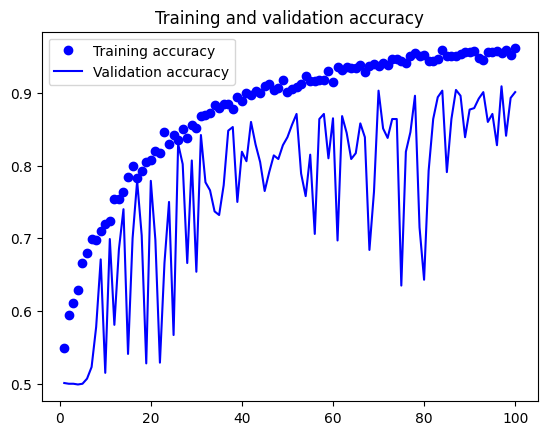

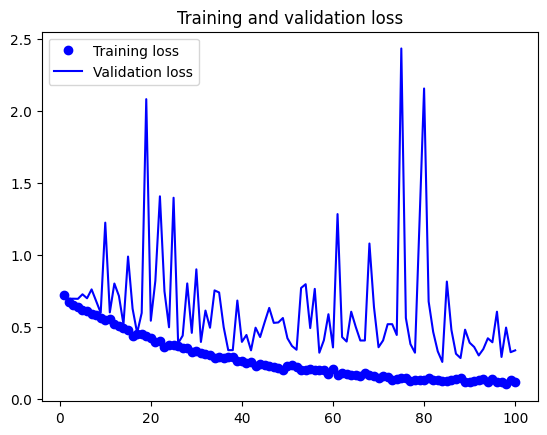

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()